## <center>Prueba Tecnica</center>
#### <center>Autor:</center>
##### <center>Sebastian Carvalho Salazar:</center>

# Modelo

La regresión logística y los bosques aleatorios son dos modelos de aprendizaje automático que podrían ser buenos para el problema de predecir el fracaso virológico en pacientes con VIH.

La regresión logística es una técnica de clasificación que se utiliza para predecir la probabilidad de un evento binario, en este caso, la ocurrencia o no del fracaso virológico.

Por otro lado, los bosques aleatorios son un conjunto de árboles de decisión que se combinan para producir una predicción (Estos modelos son útiles para reducir el riesgo de sobreajuste, aumentar la precisión en la predicción, manejar una gran cantidad de características y datos faltantes).

In [450]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

class Models:

    def __init__(self):

        self.reg = {
            'LogisticRegression': LogisticRegression(),
            'RandomForest': RandomForestClassifier(n_estimators=100 , n_jobs=-1),
        }

        self.params = {
            'LogisticRegression' : {
                'C': [0.01, 0.1, 1], 
                'solver': ['lbfgs','liblinear'], 
            }, 'RandomForest' : {
                'min_samples_split': np.arange(2,6),
                'max_leaf_nodes': np.arange(2,6),  
                'max_depth': np.arange(2,6)
            }
        }
    
    def model_export(self, clf, score):
        joblib.dump(clf, '..//models//best_model_{0:.4f}.pkl'.format(score))

    def grid_training(self, X, y):
        best_score = 999
        best_model = None
        
        for name, reg in self.reg.items():
            grid_reg = GridSearchCV(reg, self.params[name], cv=3).fit(X, y.values.ravel())
            score = np.abs(grid_reg.best_score_)

            if score < best_score:
                best_score = score
                best_model = grid_reg.best_estimator_
        
        self.model_export(best_model, best_score)
        print(best_model)
        return best_model
        
    def model_results(self, X, y, best_model):
        
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35)
        
        print("="*100)
        model = best_model
        print(model)
        
        model.fit(x_train, y_train.values.ravel())
        y_fit = model.predict(x_test)
        
        print("="*100)
        print("\n")
        
        print(classification_report(y_test,y_fit))
        cm = confusion_matrix(y_test,y_fit)
        
        print("="*100)

        plt.figure(figsize=(5,5))
        sns.heatmap(cm.T ,square=True , annot=True, cbar=False, xticklabels=True)
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        plt.show()
        
        print("="*100)
        
        #n_features = len(X.columns)
        #plt.figure(figsize=(12,8))
        #plt.barh(range(n_features), model.feature_importances_, align='center')
        #plt.yticks(np.arange(n_features), X.columns.to_list())
        #plt.xlabel("Feature importance")
        #plt.ylabel("Feature")
        #plt.grid()
        #plt.show()      
        #print("="*100)    
        #estimator = model.estimators_[10]

## Carga de Datos

Se Observa que el conjunto de datos se encuentra bastante balanceado, lo cual es conveniente e ideal para el entrenamiento del modelo, sin embargo, es importante mencionar que este conjunto de datos el cual cuenta con los pacientes que llevan en tratamiento al menos seis meses es una sub muestra bastante reducida, por lo que sería ideal contar a futuro con más observaciones para robustecer el modelo.

In [378]:
df = pd.read_excel('..//in//Datos_EDA_IMP_WL_TM.xlsx', index_col=0)

<AxesSubplot:>

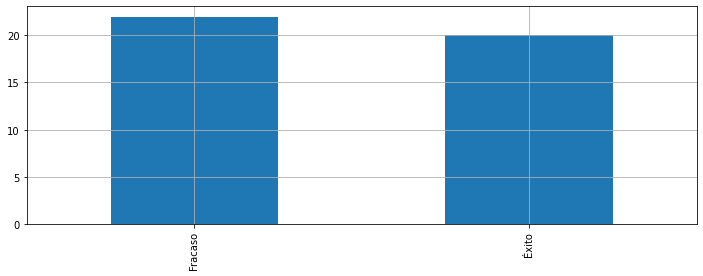

In [379]:
plt.figure(figsize=(12,4))
df['Target'].value_counts().plot(kind='bar', grid=True)

## Procesamiento

In [380]:
models = Models()

df.drop(['persistencia','tiempo_en_tratamiento_arv_meses','Label'], inplace=True, axis=1)
X = df.drop(['Target'], axis=1)
y = df['Target'].map({'Fracaso':0,'Éxito':1})

In [381]:
grid_reg = models.grid_training(X,y)

LogisticRegression(C=0.1, solver='liblinear')


LogisticRegression(C=0.1, solver='liblinear')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



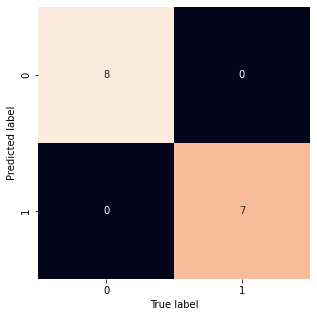

In [382]:
models.model_results(X, y, grid_reg)

## ¿Cuál y porque de la métrica de rendimiento a utilizar?

Si el label es ${1}$ se asignará Éxito en la prueba del paciente, mientras que si el label es ${0}$ se asignara Fracaso. En este tipo de problemas se le dara prioridad a la **exhaustividad (Recall)** la es una **métrica** que mide cuántas de las muestras positivas son capturadas por las predicciones positivas. Se utiliza como métrica de rendimiento cuando necesitamos identificar todas las muestras positivas; es decir, **cuando es importante evitar falsos negativos**. Ya que el caso más delicado seria decirle erróneamente a un paciente que está bien cuando en realidad podría no estarlo.

# Pruebas

### Cargar Datos

In [433]:
df = pd.read_excel('..//in//Datos_EDA_IMP_WL.xlsx', index_col=0)

### Cargar modelo

In [434]:
modelo = joblib.load("..//models//best_model_1.0000.pkl")

### Manipulación de Datos

In [435]:
df['tiempo_en_tratamiento_arv_meses'] = (df['tiempo_en_tratamiento_arv'] / 30)
df = df[(df['tiempo_en_tratamiento_arv_meses'] > 6.0) & (df['tiempo_en_tratamiento_arv_meses'] <= 8.0)]

In [436]:
df.drop(['tiempo_en_tratamiento_arv_meses'], inplace=True, axis=1)

In [437]:
df_1 = df.copy(deep=True)

In [438]:
df.drop(['persistencia','Label','Target'], inplace=True, axis=1)

### Predicciones 

Estas predicciones se realizan sobre pacientes que se encuentran en un tiempo de tratamiento mayor a seis meses, sin embargo, se toman pacientes con tiempos aunque mayores, cercanos a los seis meses. 

In [439]:
df_1['Predict'] = modelo.predict(df)
df_1['Predict'] = df_1['Predict'].map({0:'Fracaso',1:'Éxito'})

In [440]:
df_1.Predict.value_counts()

Éxito      185
Fracaso    115
Name: Predict, dtype: int64

In [445]:
df_1['is_good'] = (df_1['Target'] == df_1['Predict'])

In [448]:
df_1['is_good'].value_counts()

True     297
False      3
Name: is_good, dtype: int64

### Se Observa un Recall aceptable para ambas categorias

In [452]:
recall = recall_score(df_1['Target'].values, df_1['Predict'].values, average=None)
recall

array([1.        , 0.98404255])

### Guardar Datos

In [441]:
df_1.to_excel("..//in//Datos_EDA_IMP_WL_TM_P.xlsx")